In [1]:
# ============================
# Imports & Config
# ============================

%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm import tqdm

import wandb
wandb.login()

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Running on GPU:", torch.cuda.get_device_name(0))


wandb: Currently logged in as: nuoxu9 (nuoxu9-arizona-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


PyTorch version: 2.5.1+cu121
CUDA available: True
Running on GPU: NVIDIA RTX A6000


# Load KDD2020 NYC Taxi Dataset

The dataset contains:
- `flow`: main input tensor of size (T, 16, 12, 2)
- `trans`: dynamic origin-destination (OD) transition matrices
- `ex_knlg`: external features (weather, hour, weekday, event features)

This section loads the train/val/test `.npz` files and prints their structure.

In [3]:
# ============================
# Load KDD2020 NYC Taxi Dataset
# ============================

data_root = "/home/nuoxu9/traffic_flow_prediction/data/KDD2020/NYCTaxi"

train_path = os.path.join(data_root, "taxi_train.npz")
val_path   = os.path.join(data_root, "taxi_val.npz")
test_path  = os.path.join(data_root, "taxi_test.npz")

train_npz = np.load(train_path)
val_npz   = np.load(val_path)
test_npz  = np.load(test_path)

print("Train keys:", train_npz.files)
print("Val keys:", val_npz.files)
print("Test keys:", test_npz.files)

flow_train = train_npz["flow"]      # (T, 16, 12, 2)
trans_train = train_npz["trans"]    # (T, 16, 12, 16, 12, 2)
ex_train = train_npz["ex_knlg"]     # (T, 65)

flow_val = val_npz["flow"]
flow_test = test_npz["flow"]

print("Flow train shape:", flow_train.shape)
print("Trans train shape:", trans_train.shape)
print("Exogenous shape:", ex_train.shape)


Train keys: ['flow', 'trans', 'ex_knlg']
Val keys: ['flow', 'trans', 'ex_knlg']
Test keys: ['flow', 'trans', 'ex_knlg']
Flow train shape: (1920, 16, 12, 2)
Trans train shape: (1920, 16, 12, 16, 12, 2)
Exogenous shape: (1920, 65)


# Visualize the Data

Before training, we visualize:

1. A heatmap of inflow/outflow for a specific timestep.
2. Time series at a selected grid cell.

This helps us confirm that:
- The dataset loaded correctly.
- Patterns look realistic.
- The grid structure is meaningful.


Sample inflow shape: (16, 12)
Sample outflow shape: (16, 12)


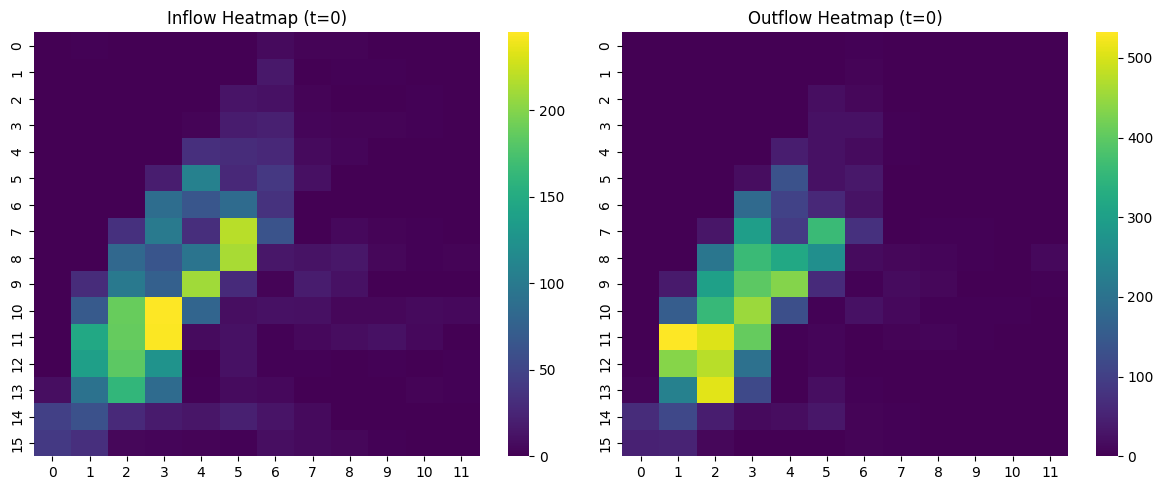

In [4]:
# ============================
# Inspect & Visualize Dataset
# ============================

# Choose a timestep to inspect
t = 0

sample_flow = flow_train[t]   # shape: (16, 12, 2)
inflow  = sample_flow[:, :, 0]
outflow = sample_flow[:, :, 1]

print("Sample inflow shape:", inflow.shape)
print("Sample outflow shape:", outflow.shape)

# Plot inflow & outflow side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Inflow Heatmap (t=0)")
sns.heatmap(inflow, cmap='viridis')

plt.subplot(1, 2, 2)
plt.title("Outflow Heatmap (t=0)")
sns.heatmap(outflow, cmap='viridis')

plt.tight_layout()
plt.show()


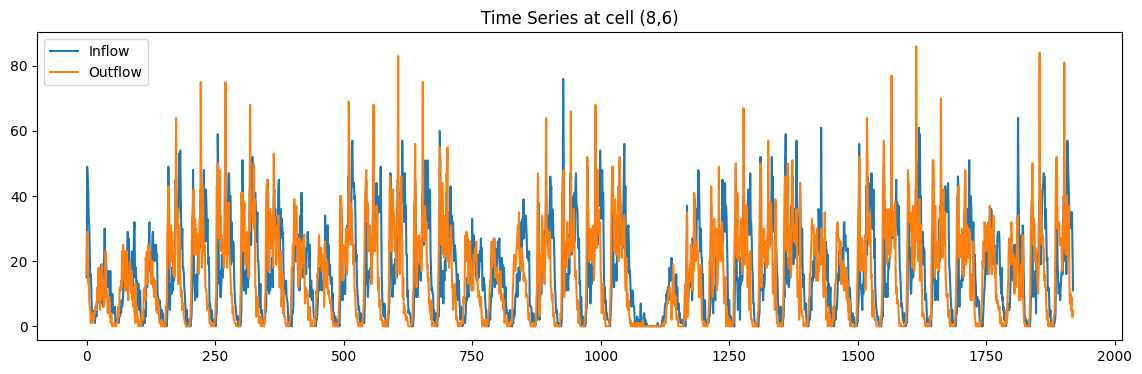

In [5]:
i, j = 8, 6

ts_in = flow_train[:, i, j, 0]
ts_out = flow_train[:, i, j, 1]

plt.figure(figsize=(14, 4))
plt.plot(ts_in, label="Inflow")
plt.plot(ts_out, label="Outflow")
plt.legend()
plt.title(f"Time Series at cell ({i},{j})")
plt.show()


### Interpretation

- The **heatmaps** should show spatial distributions of traffic inflow/outflow.
- The **time series** should show daily & weekly periodic patterns typical of traffic data.

If the plots look smooth and structured, the dataset is correct and ready for modeling.


# Normalization & Sliding Window Creation

Traffic flow values vary significantly by location and time.  
Neural networks train much more effectively when inputs are normalized.

Here we will:

1. Compute the mean and standard deviation using the **training set only**  
2. Normalize train/val/test  
3. Convert time series into supervised learning samples using a sliding window  
   - **Input length = 12 timesteps**  
   - **Output length = 3 timesteps**

This produces tensors of shape:

- `X`: (num_samples, 12, 16, 12, 2)
- `Y`: (num_samples, 3, 16, 12, 2)


In [6]:
# ============================
# Normalization
# ============================

# Compute mean & std using *only* training data
flow_mean = flow_train.mean(axis=(0, 1, 2))
flow_std  = flow_train.std(axis=(0, 1, 2)) + 1e-6  # avoid division by zero

print("Flow mean:", flow_mean)
print("Flow std:", flow_std)

def normalize(x):
    return (x - flow_mean) / flow_std

def denormalize(x):
    return x * flow_std + flow_mean

# Normalize datasets
flow_train_norm = normalize(flow_train)
flow_val_norm   = normalize(flow_val)
flow_test_norm  = normalize(flow_test)


Flow mean: [32.01392415 32.01924099]
Flow std: [89.42449993 97.83843562]


### Sliding Window Construction

We transform the continuous time series into (X, Y) pairs where:

- `X[t] = flow[t : t+12]`
- `Y[t] = flow[t+12 : t+15]`

This gives:
- multiple training samples
- consistent window lengths
- fixed temporal receptive fields for models


In [7]:
def create_dataset(flow_data, input_len=12, output_len=3):
    X, Y = [], []
    T = flow_data.shape[0]

    for t in range(T - input_len - output_len):
        X.append(flow_data[t : t + input_len])            # [12, 16, 12, 2]
        Y.append(flow_data[t + input_len : t + input_len + output_len])  # [3, 16, 12, 2]

    return np.array(X), np.array(Y)


X_train, Y_train = create_dataset(flow_train_norm)
X_val,   Y_val   = create_dataset(flow_val_norm)
X_test,  Y_test  = create_dataset(flow_test_norm)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

print("Train samples:", len(X_train))
print("Val samples:", len(X_val))
print("Test samples:", len(X_test))



X_train: (1905, 12, 16, 12, 2)
Y_train: (1905, 3, 16, 12, 2)
Train samples: 1905
Val samples: 561
Test samples: 945


### Build PyTorch Dataset & DataLoader

We now convert numpy arrays into PyTorch tensors and create DataLoaders for:
- training
- validation
- testing

This allows batching and shuffling during model training.


In [8]:
class TrafficDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


batch_size = 32

train_loader = DataLoader(TrafficDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TrafficDataset(X_val,   Y_val),   batch_size=batch_size)
test_loader  = DataLoader(TrafficDataset(X_test,  Y_test),  batch_size=batch_size)

print("Train batches:", len(train_loader))


Train batches: 60


# STGCN Implementation

STGCN uses:
- Temporal Conv (TCN)
- Graph Conv (GCN)
- Stacked ST-blocks

Before defining the model, we construct the grid adjacency matrix for the 16×12 map.
Each grid cell connects to its 4 neighbors (up, down, left, right).


In [9]:
# ============================
# Build Adjacency Matrix for 16x12 Grid
# ============================

H, W = 16, 12
N = H * W

def build_grid_adj(H, W):
    A = np.zeros((H * W, H * W))
    
    def node_id(i, j):
        return i * W + j

    for i in range(H):
        for j in range(W):
            idx = node_id(i, j)

            # connect up
            if i > 0:
                A[idx, node_id(i-1, j)] = 1
            # connect down
            if i < H - 1:
                A[idx, node_id(i+1, j)] = 1
            # connect left
            if j > 0:
                A[idx, node_id(i, j-1)] = 1
            # connect right
            if j < W - 1:
                A[idx, node_id(i, j+1)] = 1

    return A

A = build_grid_adj(H, W)

print("Adjacency shape:", A.shape)
print("Non-zero connections:", (A>0).sum())

# ============================
# Normalize adjacency matrix
# ============================

A_torch = torch.tensor(A, dtype=torch.float32)

I = torch.eye(N)
A_hat = A_torch + I

# D^{-1/2}
D = torch.diag(torch.pow(A_hat.sum(1), -0.5))
A_norm = D @ A_hat @ D

A_norm = A_norm.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print("A_norm ready:", A_norm.shape)


Adjacency shape: (192, 192)
Non-zero connections: 712
A_norm ready: torch.Size([192, 192])


In [10]:
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.theta = nn.Linear(in_channels, out_channels)

    def forward(self, X, A_norm):
        # X shape: (batch, nodes, in_channels)
        AX = torch.matmul(A_norm, X)  # (batch, nodes, in_channels)
        out = self.theta(AX)  # linear transform
        return out

class TemporalConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(kernel_size, 1),
            padding=(kernel_size//2, 0)
        )

    def forward(self, x):
        # x shape: (batch, T, N, C)
        # rearrange to (batch, C, T, N)
        x = x.permute(0, 3, 1, 2)
        out = self.conv(x)
        out = out.permute(0, 2, 3, 1)  # back to (batch, T, N, C)
        return out

class STBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.tconv1 = TemporalConv(in_channels, out_channels)
        self.gcn    = GCN(out_channels, out_channels)
        self.tconv2 = TemporalConv(out_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, A_norm):
        # x: (batch, T, N, C)
        out = self.tconv1(x)
        
        # GCN on each timestep
        B, T, N, C = out.shape
        out2 = []
        for t in range(T):
            out2.append(self.gcn(out[:, t], A_norm))
        out = torch.stack(out2, dim=1)

        out = self.tconv2(out)
        return self.relu(out)

class STGCN(nn.Module):
    def __init__(self, in_channels=2, hidden=32, output_steps=3, ):
        super().__init__()
        self.output_steps = output_steps
        self.st1 = STBlock(in_channels, hidden)
        self.st2 = STBlock(hidden, hidden)
        self.final = nn.Conv2d(
            in_channels=hidden,
            out_channels=output_steps * 2,  # 2 channels output per step
            kernel_size=(1, 1)
        )

    def forward(self, x, A_norm):
        """
        x: (batch, T, H, W, C)
        reshape to (batch, T, N, C)
        """
        B, T, H, W, C = x.shape
        x = x.reshape(B, T, H*W, C)

        out = self.st1(x, A_norm)
        out = self.st2(out, A_norm)

        # collapse time dimension -> output_steps
        out = out.permute(0, 3, 1, 2)  # (B, C, T, N)
        out = self.final(out)          # (B, output_steps*2, T, N)

        # take the last T dimension only
        out = out[:, :, -1]            # (B, output_steps*2, N)

        # reshape back
        out = out.reshape(B, self.output_steps, 2, H, W).permute(0,1,3,4,2)
        return out


# Training Loop for STGCN

This section defines the training and validation loops for STGCN.  
We use:

- **MSE loss** for regression  
- **Adam optimizer**  
- **Mini-batch training**  
- **Validation after each epoch**  
- **Best-model saving**

This will let us monitor model performance and prevent overfitting.


In [13]:
# ============================
# wandb initialization
# ============================

wandb.init(
    project="traffic_prediction",
    name="stgcn_kdd2020",
    config={
        "model": "STGCN",
        "hidden_size": 32,
        "input_len": 12,
        "output_len": 3,
        "batch_size": 32,
        "learning_rate": 1e-3,
        "epochs": 100,
    }
)

# ============================
# Training Loop
# ============================
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0

    for X, Y in loader:
        X = X.to(device)   # (B, 12, 16, 12, 2)
        Y = Y.to(device)   # (B,  3, 16, 12, 2)

        optimizer.zero_grad()
        preds = model(X, A_norm)       # (B, 3, 16, 12, 2)

        loss = criterion(preds, Y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X, Y in loader:
            X = X.to(device)
            Y = Y.to(device)

            preds = model(X, A_norm)
            loss = criterion(preds, Y)
            total_loss += loss.item()

    return total_loss / len(loader)

# ============================
# Train STGCN
# ============================

model = STGCN(in_channels=2, hidden=32, output_steps=3).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
best_val_loss = float('inf')
patience = 10
patience_counter = 0

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=5, verbose=True
)

for epoch in range(num_epochs):
    # --- Training ---
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    
    # --- Validation ---
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Update LR scheduler
    scheduler.step(val_loss)

    # --- wandb logging ---
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_loss": val_loss,
    })

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    # --- Best Model Saving ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save model
        torch.save(model.state_dict(), "stgcn_best.pth")
        wandb.log({"best_val_loss": best_val_loss})
        
        print("  -> Saved new best model")
    else:
        patience_counter += 1

    # --- Early Stopping ---
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
wandb.finish()

/home/nuoxu9/.conda/envs/traffic/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 0.456362 | Val Loss: 0.272870
  -> Saved new best model
Epoch 2/100 | Train Loss: 0.214904 | Val Loss: 0.225481
  -> Saved new best model
Epoch 3/100 | Train Loss: 0.192066 | Val Loss: 0.223682
  -> Saved new best model
Epoch 4/100 | Train Loss: 0.181269 | Val Loss: 0.205731
  -> Saved new best model
Epoch 5/100 | Train Loss: 0.172853 | Val Loss: 0.196445
  -> Saved new best model
Epoch 6/100 | Train Loss: 0.164094 | Val Loss: 0.184443
  -> Saved new best model
Epoch 7/100 | Train Loss: 0.155514 | Val Loss: 0.172740
  -> Saved new best model
Epoch 8/100 | Train Loss: 0.146570 | Val Loss: 0.168355
  -> Saved new best model
Epoch 9/100 | Train Loss: 0.145793 | Val Loss: 0.166380
  -> Saved new best model
Epoch 10/100 | Train Loss: 0.140850 | Val Loss: 0.164136
  -> Saved new best model
Epoch 11/100 | Train Loss: 0.135273 | Val Loss: 0.151874
  -> Saved new best model
Epoch 12/100 | Train Loss: 0.128501 | Val Loss: 0.154698
Epoch 13/100 | Train Loss: 0.124305 | V

best_val_loss,█▆▆▅▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
train_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_loss,0.10909
epoch,100
train_loss,0.09099
val_loss,0.11135


### Training & Validation Loss Over Epochs
This plot helps us diagnose overfitting or underfitting.


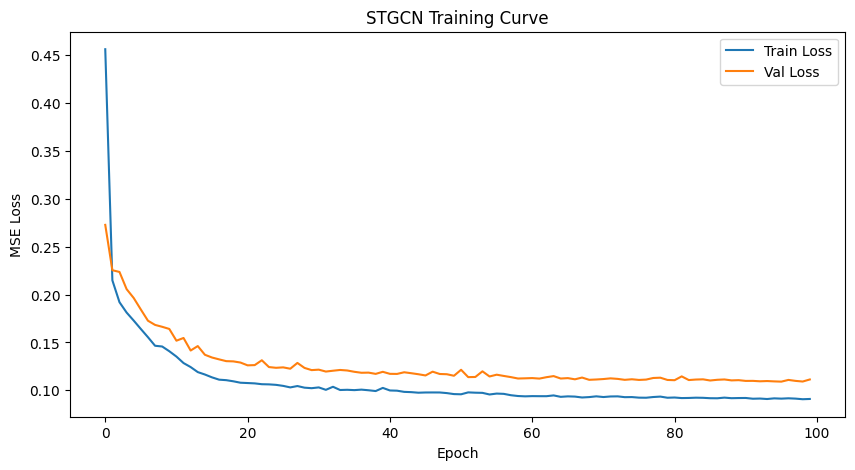

In [14]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("STGCN Training Curve")
plt.show()


# STGCN Evaluation & Prediction Visualization

Now that STGCN is trained, we:
1. Load the best checkpoint
2. Run predictions on the validation/test set
3. Visualize:
   - heatmaps (GT vs Pred)
   - time series at selected grid cells
4. Compute MAE / RMSE metrics

/tmp/ipykernel_3520153/2399633975.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("stgcn_best.pth"))


Loaded best STGCN model.
Preds shape: torch.Size([32, 3, 16, 12, 2])
GT shape: torch.Size([32, 3, 16, 12, 2])


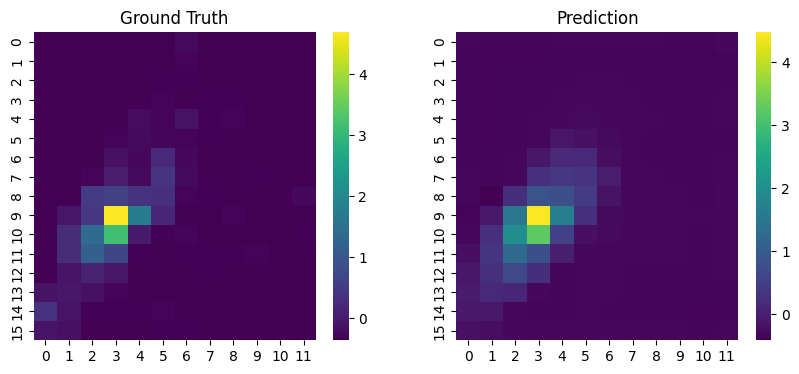

Validation MAE:  0.138907
Validation RMSE: 0.334155


In [15]:
# ============================
# Load Best STGCN Model
# ============================

best_model = STGCN(in_channels=2, hidden=32, output_steps=3).to(device)
best_model.load_state_dict(torch.load("stgcn_best.pth"))
best_model.eval()

print("Loaded best STGCN model.")

# ============================
# Predict on validation batch
# ============================

X_batch, Y_batch = next(iter(val_loader))

X_batch = X_batch.to(device)
Y_batch = Y_batch.to(device)

with torch.no_grad():
    preds = best_model(X_batch, A_norm)  # (B, 3, 16, 12, 2)

print("Preds shape:", preds.shape)
print("GT shape:", Y_batch.shape)


# ============================
# GT vs Prediction Heatmap
# ============================

b = 0   # sample index
t = 0   # predicted timestep (0,1,2)
ch = 0  # 0=inflow, 1=outflow

gt = Y_batch[b, t, :, :, ch].cpu().numpy()
pd = preds[b, t, :, :, ch].cpu().numpy()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("Ground Truth")
sns.heatmap(gt, cmap="viridis")

plt.subplot(1,2,2)
plt.title("Prediction")
sns.heatmap(pd, cmap="viridis")

plt.show()

# ============================
# Compute MAE & RMSE
# ============================

mae = torch.mean(torch.abs(preds - Y_batch)).item()
rmse = torch.sqrt(torch.mean((preds - Y_batch)**2)).item()

print(f"Validation MAE:  {mae:.6f}")
print(f"Validation RMSE: {rmse:.6f}")


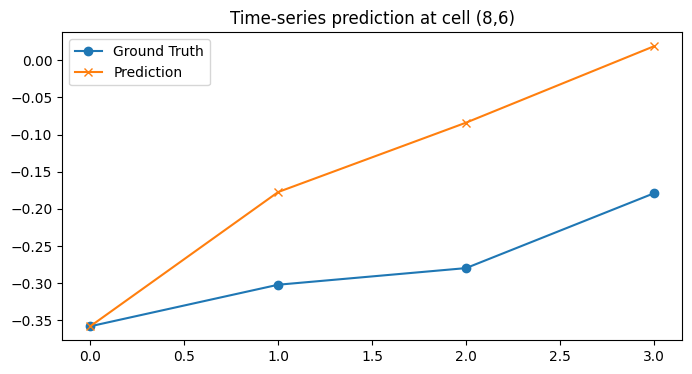

In [16]:
# ============================
# Time-series comparison
# ============================

i, j = 8, 6

# extract:
# - last input timestep
# - GT next 3 steps
# - Pred next 3 steps
input_last = X_batch[b, -1, i, j, ch].cpu().numpy()
gt_series = Y_batch[b, :, i, j, ch].cpu().numpy()
pd_series = preds[b, :, i, j, ch].cpu().numpy()

# build combined series
series_gt = np.concatenate([[input_last], gt_series])
series_pd = np.concatenate([[input_last], pd_series])

plt.figure(figsize=(8,4))
plt.plot(series_gt, marker="o", label="Ground Truth")
plt.plot(series_pd, marker="x", label="Prediction")
plt.title(f"Time-series prediction at cell ({i},{j})")
plt.legend()
plt.show()


STGCN preds: torch.Size([32, 3, 16, 12, 2])
GT: torch.Size([32, 3, 16, 12, 2])


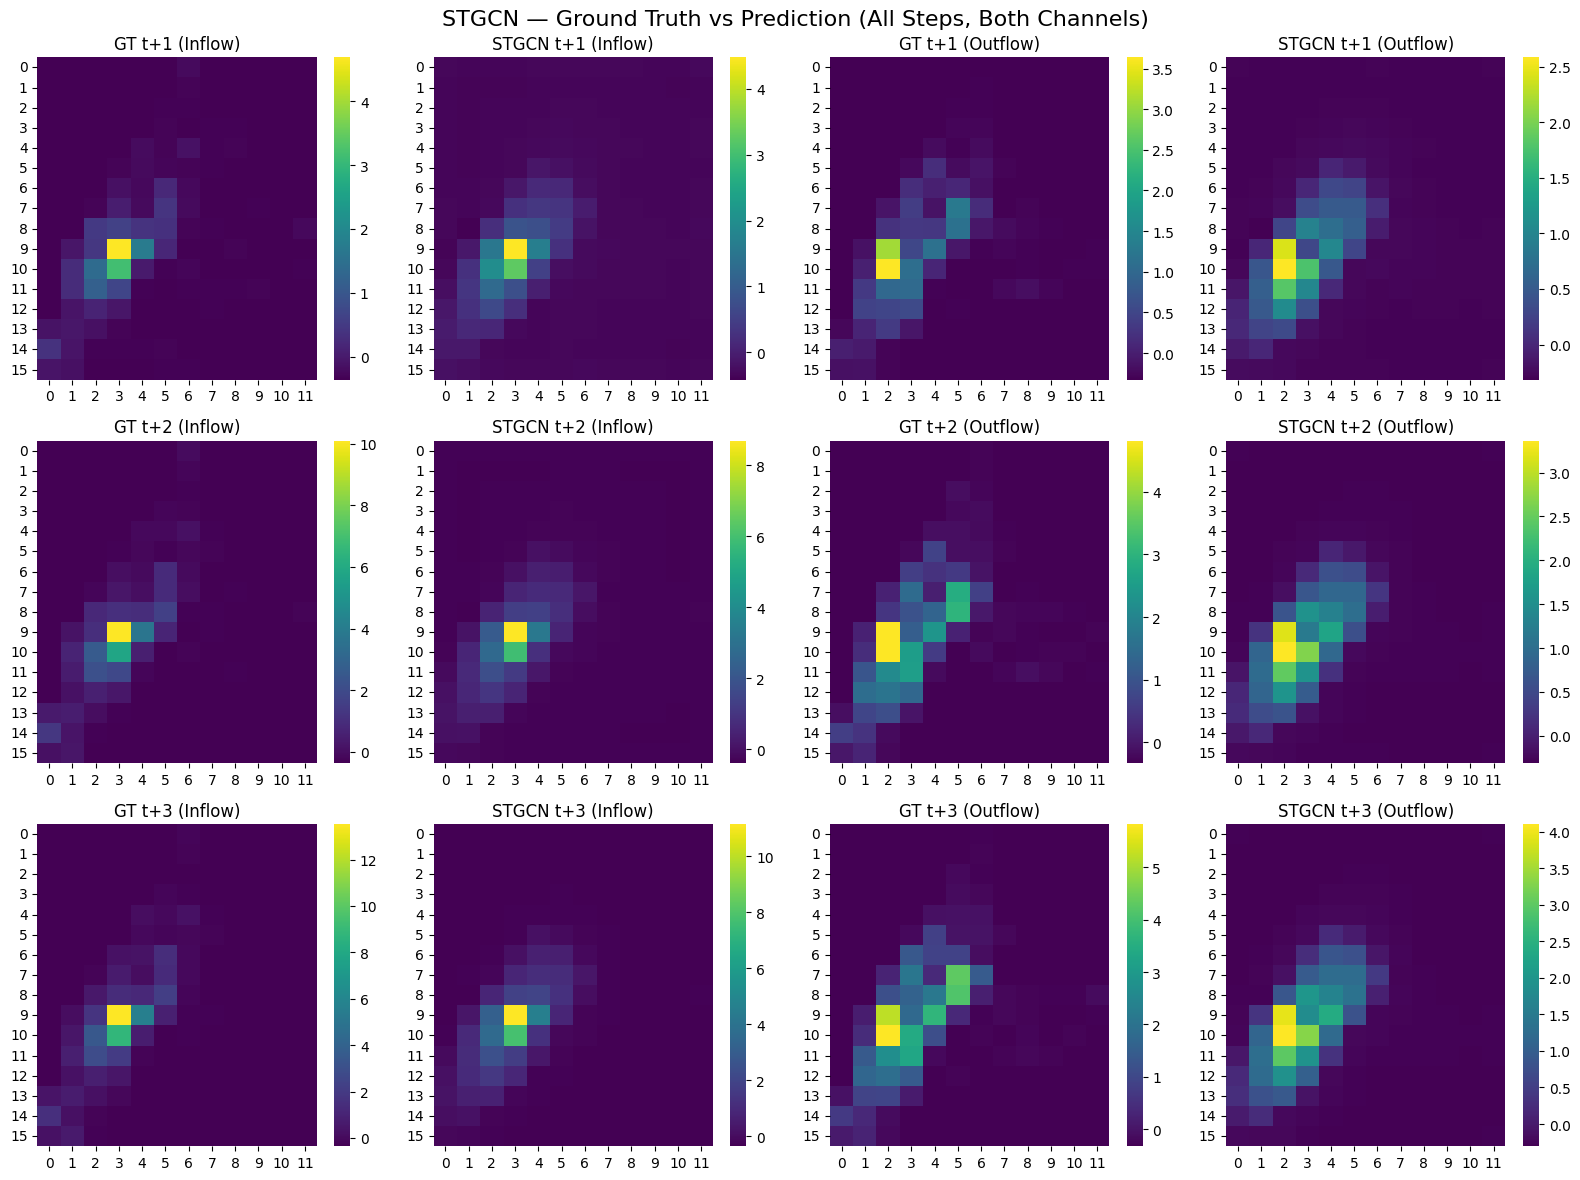

In [22]:
# ============================
# Select one validation batch
# ============================
X_batch, Y_batch = next(iter(val_loader))
Xb = X_batch.to(device)
Yb = Y_batch.to(device)

# ============================
# Run STGCN on batch
# ============================
with torch.no_grad():
    preds_stgcn = best_model(Xb, A_norm)   # (B,3,16,12,2)

print("STGCN preds:", preds_stgcn.shape)
print("GT:", Yb.shape)

# ============================
# Visualization (3 steps × 2 channels)
# ============================

import seaborn as sns
import matplotlib.pyplot as plt

b = 0  # sample index
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle("STGCN — Ground Truth vs Prediction (All Steps, Both Channels)", fontsize=16)

steps = ["t+1", "t+2", "t+3"]
channels = ["Inflow", "Outflow"]

for t in range(3):              # t+1, t+2, t+3
    for ch in range(2):         # 0=inflow, 1=outflow

        gt  = Yb[b, t, :, :, ch].cpu().numpy()
        pred = preds_stgcn[b, t, :, :, ch].cpu().numpy()

        ax_gt   = axes[t, ch*2]
        ax_pred = axes[t, ch*2 + 1]

        sns.heatmap(gt, ax=ax_gt, cmap="viridis")
        sns.heatmap(pred, ax=ax_pred, cmap="viridis")

        ax_gt.set_title(f"GT {steps[t]} ({channels[ch]})")
        ax_pred.set_title(f"STGCN {steps[t]} ({channels[ch]})")

plt.tight_layout()
plt.show()
